In [ ]:
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
import decoupler

import os
import sys
import logging
import warnings
from utils import *

In [53]:
adata_female_file = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/female_98_80.h5ad'
adata_male_file = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/male_98_85.h5ad'
#adata_with_features_file = 
adata_female = sc.read_h5ad(adata_female_file)
adata_male = sc.read_h5ad(adata_male_file)

In [54]:
# subset to skeletal muscle stem cells
adata_musc_f = adata_female[adata_female.obs['C_scANVI'] == 'Skeleton MuSc']
adata_musc_m = adata_male[adata_male.obs['C_scANVI'] == 'Skeleton MuSc']

## Geneset (atrophy/senescence) scores

In [69]:
custom_atrophy_pathway = ["UBB","UBC","FBXO32","TRIM63","MDM2","FBXO30","CAMK2B","TIE1","PSMA1","PSMA2","PSMA3","PSMA4","PSMA5","PSMA6","PSMA7","PSMB1","PSMB2","PSMB3","PSMB4","FBXO21","FBXO31","NEDD4","UBE2B","UBE2G1","UBE2J1","CTSL","CTSV","BNIP3","DEPP1","GABARAPL1","MAP1LC3","RETREG1","SQSTM1","CAPN1","CAPN2","ATF4","FOXO1","FOXO3A","HDAC9","RUNX1","AMPD3","CHRNA1","CDKN1A"]
# Convert to mouse gene format
custom_atrophy_pathway_mouse = [gene.capitalize() for gene in custom_atrophy_pathway]
print(custom_atrophy_pathway_mouse)

['Ubb', 'Ubc', 'Fbxo32', 'Trim63', 'Mdm2', 'Fbxo30', 'Camk2b', 'Tie1', 'Psma1', 'Psma2', 'Psma3', 'Psma4', 'Psma5', 'Psma6', 'Psma7', 'Psmb1', 'Psmb2', 'Psmb3', 'Psmb4', 'Fbxo21', 'Fbxo31', 'Nedd4', 'Ube2b', 'Ube2g1', 'Ube2j1', 'Ctsl', 'Ctsv', 'Bnip3', 'Depp1', 'Gabarapl1', 'Map1lc3', 'Retreg1', 'Sqstm1', 'Capn1', 'Capn2', 'Atf4', 'Foxo1', 'Foxo3a', 'Hdac9', 'Runx1', 'Ampd3', 'Chrna1', 'Cdkn1a']


In [56]:
sensig_geneset_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/SenSig_DEGs.csv'
fridman_down_orthologs_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/fridman_down_orthologs.csv'
fridman_up_orthologs_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/fridman_up_orthologs.csv'
senmayo_geneset_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/SAUL_SEN_MAYO_UP_IN_SEN.v2024.1.Mm.gmt'
cell_age_orthologs_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/cellAge_orthologs.csv'
cell_age_human_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/cellAge/cellage3.tsv'

In [57]:
#SenSig
sensig_genes = pd.read_csv(sensig_geneset_file, skiprows=1)
sensig_up_genes = sensig_genes[sensig_genes['logFC'] > 0]['Gene'].tolist()  
sensig_down_genes = sensig_genes[sensig_genes['logFC'] < 0]['Gene'].tolist()
print(len(sensig_up_genes))
print(len(sensig_down_genes))
#Fridman gene sets
fridman_down_orthologs = pd.read_csv(fridman_down_orthologs_file, sep=',', header=0)['ortholog_name'].tolist()
fridman_up_orthologs = pd.read_csv(fridman_up_orthologs_file, sep=',', header=0)['ortholog_name'].tolist()
display(fridman_down_orthologs[0:5])
display(fridman_up_orthologs[0:5])
#SenMayo
senmayo_genes = pd.read_csv(senmayo_geneset_file, sep='\t', header=None)
senmayo_up_genes = senmayo_genes.iloc[0, 2:].dropna().tolist()
display(senmayo_up_genes[0:5])
cellage_orthologs = pd.read_csv(cell_age_orthologs_file, sep=',', header=0)
cellage_human = pd.read_csv(cell_age_human_file, sep='\t', header=0)

# Merge based on initial_alias (from orthologs) matching Gene symbol (from cellage)
merged = pd.merge(
    cellage_orthologs[['ortholog_name', 'initial_alias']], # Keep only these columns
    cellage_human[['Gene symbol', 'Senescence Effect']],
    left_on='initial_alias',
    right_on='Gene symbol',
    how='left'
)

# Clean up the merged dataframe
merged = merged.drop('Gene symbol', axis=1)  # Remove the redundant column
cellage_ortholog_genes = merged.rename(columns={'initial_alias': 'human_gene'})
# get the cellage_up_genes as ortholog_name
cellage_up_genes = cellage_ortholog_genes[cellage_ortholog_genes['Senescence Effect'] == 'Induces']['ortholog_name'].tolist()
display(cellage_up_genes[0:5])
# get the cellage_down_genes as ortholog_name 
cellage_down_genes = cellage_ortholog_genes[cellage_ortholog_genes['Senescence Effect'] == 'Inhibits']['ortholog_name'].tolist()
display(cellage_down_genes[0:5])


8567
9069


['Aldh1a7', 'Aldh1a1', 'Bmi1', 'Ccn4', 'Ccnb1']

['Aldh1a3', 'Aopep', 'Ccn2', 'Ccnd1', 'Cd44']

['Acvr1b', 'Ang', 'Angpt1', 'Angptl4', 'Areg']

['Aak1', 'Abcb1b', 'Abcb1a', 'Abi3', 'Abi3bp']

['Abcc6', 'Acer2', 'Acer2', 'Acer2', 'Acer2']

In [ ]:
scores = calculate_sc_score(
    data=adata_musc_f,  # Pass AnnData directly
    up_genes=custom_atrophy_pathway_mouse,
    down_genes=None,
    condition_col='condition'
)
display(scores)

Converting AnnData to DataFrame...
Extracted 'condition' column from obs
Converted to DataFrame with shape: (1299, 362) (genes x cells)
Using 7 upregulated genes


,senescence_score,condition
AAGTACCAGAGCAGAA-1,-1.056469,KO
AAGTACCTCGTTTACT-1,0.088695,KO
AATAGAGTCGTCAGAT-1,0.709179,KO
ACTATGGCAAATCAAG-1,-0.099984,KO
AGTGTTGTCCGCAAAT-1,-1.565860,KO
...,...,...
TGCATTAGTTATCTCT-1,0.361666,WT
TGGGCAGGTGGCTGAG-1,2.430134,WT
TGGGTCCGTTTGCCCT-1,1.467064,WT
TGTAAGGGTTGCTAAC-1,-0.562909,WT


/tmp/ipykernel_73668/1714250827.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violin = sns.violinplot(
/tmp/ipykernel_73668/1714250827.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


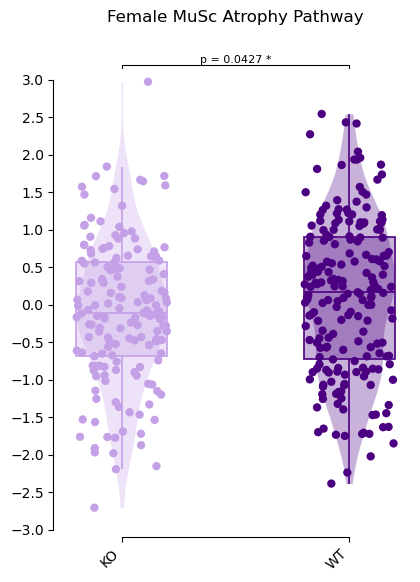

<Figure size 640x480 with 0 Axes>

In [74]:
custom_colors = {
    'KO': '#C4A0E7',      # '#66C2D7' Soft teal blue '#C4A0E7',# Light lavender
    'WT': '#4B0082'   # '#2E86AB' Deeper teal blue, '#4B0082' # Indigo
}

fig = plot_violin_box_combo(
    data=scores,
    x_var='condition',
    y_var='senescence_score',
    title='Female MuSc Atrophy Pathway',
    x_ticks=scores['condition'].unique(),
    palette=custom_colors,
    rotation=45
)

# Display the plot
from IPython.display import display
display(fig)
# save as pdf 
#fig.savefig('/ocean/projects/cis240075p/asachan/datasets/senescence_datasets/mouse_liver/figures/cellage_scores.pdf', bbox_inches='tight')